# Applying Long Short-Term Memory (LSTM) (DEEPAR) networks to Virtual Flow Metering (VFM)

## Author: Ridha Alkhabaz

### Imports:

In [38]:
import os
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML/src')
from preprocessing import read_data_slugging, read_data_well
from configuration import configure 
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML')
import datetime
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from itertools import islice
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.field_names import FieldName

#### The Slugging data set:

In [39]:
def time_to_timestamp(seconds):
    addition = 1625893200
    minutes = seconds * 60 
    minutes += addition
    timestamp = datetime.datetime.fromtimestamp(minutes)
    return timestamp.strftime('%Y-%m-%d %H:%M:%S')

In [40]:
data_riser,headers, _= read_data_slugging('riser_pq_uni.csv', plot_data=False)
df_riser = pd.DataFrame.from_dict(dict(zip(['ds', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas', 'liquid' ], data_riser.T)))
df_riser = df_riser.iloc[75:, :]
df_riser['date'] = df_riser['ds'].apply(time_to_timestamp)
df_riser = df_riser.set_index('date')
df_riser = df_riser.drop(['ds'], axis=1)
# (pd.to_datetime(df_riser['date']).diff().dt.total_seconds() / 60).value_counts()
# use less data find if there is any irregularity from minute and seconds

In [5]:
273*3

819

In [ ]:
prediction_length=273
training_data_mult = ListDataset(
    [{"start":df_riser.index[0], "feat_dynamic_real":df_riser.iloc[:,0:7].values, "target":df_riser.gas[:'2021-07-11 11:00:00']}],
    freq = "1min"
)

In [41]:
[{"start":df_riser.index[0], "feat_dynamic_real":df_riser.iloc[:,0:7].values, "target":df_riser.gas[:'2021-07-11 11:00:00']}]

[{'start': '2021-07-10 01:15:00',
  'feat_dynamic_real': array([[0.88571525, 0.86391454, 0.69314228, ..., 0.31389014, 0.14440649,
          0.01554568],
         [0.88778547, 0.86596786, 0.69512801, ..., 0.31363242, 0.14446564,
          0.01607803],
         [0.88981345, 0.86801273, 0.69702923, ..., 0.31331977, 0.14449099,
          0.01662304],
         ...,
         [0.80996513, 0.78827082, 0.61806189, ..., 0.20421136, 0.01662383,
          0.00402535],
         [0.81190547, 0.79020803, 0.6199772 , ..., 0.20604217, 0.01777864,
          0.00402223],
         [0.81291946, 0.79120324, 0.62093798, ..., 0.20718917, 0.01824965,
          0.00413833]]),
  'target': date
  2021-07-10 01:15:00    0.179369
  2021-07-10 01:16:00    0.179538
  2021-07-10 01:17:00    0.179584
  2021-07-10 01:18:00    0.179580
  2021-07-10 01:19:00    0.179640
                           ...   
  2021-07-11 10:56:00    0.178355
  2021-07-11 10:57:00    0.179646
  2021-07-11 10:58:00    0.180159
  2021-07-11 10:59

In [58]:
a = {'freq':'1min', 'context_length':1080, 'prediction_length':270, \
     'num_layers':4, 'num_cells':256, 'cell_type':'lstm', 'trainer':Trainer(epochs=2)}

In [59]:
modela = DeepAREstimator(**a)

In [42]:
model = DeepAREstimator(freq='1min', context_length=1080, \
                        prediction_length=prediction_length,num_layers=4, num_cells=256,\
                        cell_type='lstm', trainer=Trainer(epochs=10))
                # capture the terminal output and plot it 

In [43]:
predictor = model.train(training_data_mult)


100%|██████████| 50/50 [55:29<00:00, 66.58s/it, epoch=1/10, avg_epoch_loss=-1.75]

100%|██████████| 50/50 [49:19<00:00, 59.18s/it, epoch=2/10, avg_epoch_loss=-2.31]

100%|██████████| 50/50 [43:06<00:00, 51.72s/it, epoch=3/10, avg_epoch_loss=-2.38]

 80%|████████  | 40/50 [36:40<10:17, 61.72s/it, epoch=4/10, avg_epoch_loss=-3.12]


100%|██████████| 50/50 [45:46<00:00, 54.92s/it, epoch=4/10, avg_epoch_loss=-2.92]

100%|██████████| 50/50 [52:41<00:00, 63.22s/it, epoch=5/10, avg_epoch_loss=-2.92]

100%|██████████| 50/50 [46:08<00:00, 55.37s/it, epoch=6/10, avg_epoch_loss=-3.51]

100%|██████████| 50/50 [1:03:02<00:00, 75.65s/it, epoch=7/10, avg_epoch_loss=-3.6] 

 60%|██████    | 30/50 [31:09<23:11, 69.58s/it, epoch=8/10, avg_epoch_loss=-3.49]


100%|██████████| 50/50 [54:17<00:00, 65.15s/it, epoch=8/10, avg_epoch_loss=-3.44]

100%|██████████| 50/50 [52:23<00:00, 62.87s/it, epoch=9/10, avg_epoch_loss=-3.7] 

100%|██████████| 50/50 [47:25<00:00, 56.91s/it, epoch=10/10, avg_epoch_loss=-3.7]


In [45]:
from pathlib import Path
predictor.serialize(Path("/tmp/"))

# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = predictor.deserialize(Path("/tmp/"))

In [46]:
test_data = ListDataset(
    [{"start": df_riser.index[0], "target": df_riser.gas[:'2021-07-11 11:00:00']}, 
    {"start": df_riser.index[0], "target": df_riser.gas[:'2021-07-12 01:59:00']}],
    freq = "1min"
)

In [47]:
forecast_it, test_it = make_evaluation_predictions(
    dataset=test_data,
    predictor=predictor, 
    num_samples=1000
)

In [48]:
forecasts = list(forecast_it)

In [49]:
tss = list(test_it)

In [50]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metric, item_metrics= evaluator(iter(tss), iter(forecasts), num_series=len(test_data))


Running evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


In [51]:
agg_metric

{'MSE': 0.022748901730492002,
 'abs_error': 36.113006591796875,
 'abs_target_sum': 118.96451950073242,
 'abs_target_mean': 0.21788373534932676,
 'seasonal_error': 0.09894927740436427,
 'MASE': 0.66944966969481,
 'MAPE': 0.27802876063755577,
 'sMAPE': 0.2630296644273695,
 'MSIS': 20.23542768085608,
 'QuantileLoss[0.1]': 9.687109817564487,
 'Coverage[0.1]': 0.018315018315018316,
 'QuantileLoss[0.5]': 36.11300674080849,
 'Coverage[0.5]': 0.02197802197802198,
 'QuantileLoss[0.9]': 53.53159885108471,
 'Coverage[0.9]': 0.04212454212454213,
 'RMSE': 0.15082739051807534,
 'NRMSE': 0.6922379510166654,
 'ND': 0.30356115204226536,
 'wQuantileLoss[0.1]': 0.08142856255141556,
 'wQuantileLoss[0.5]': 0.30356115329483724,
 'wQuantileLoss[0.9]': 0.4499795323491819,
 'mean_absolute_QuantileLoss': 33.11057180315256,
 'mean_wQuantileLoss': 0.27832308273181156,
 'MAE_Coverage': 0.47252747252747257,
 'OWA': nan}

In [52]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 1000
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

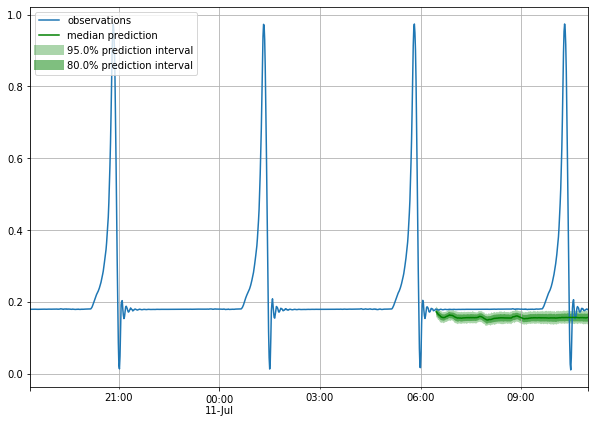

In [53]:
plot_prob_forecasts(tss[0], forecasts[0])

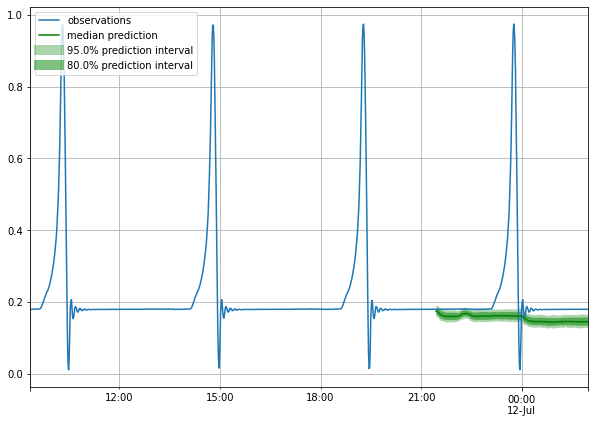

In [54]:
plot_prob_forecasts(tss[1], forecasts[1])

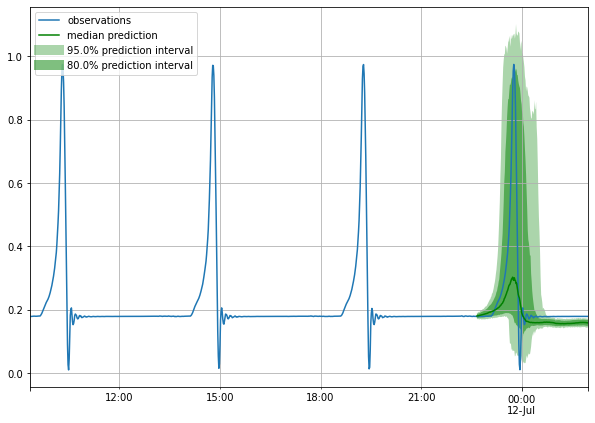

In [30]:
plot_prob_forecasts(tss[1], forecasts[1])

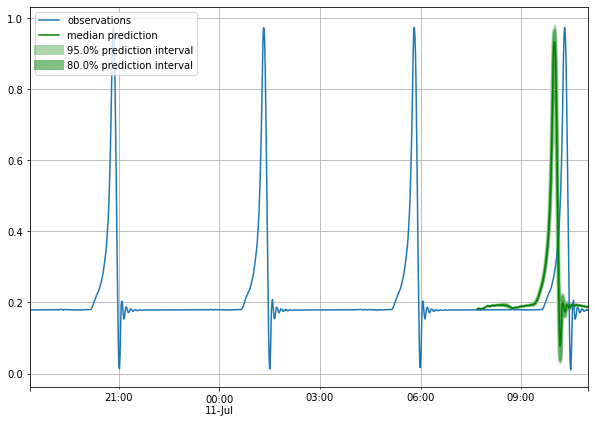

In [25]:
plot_prob_forecasts(tss[0], forecasts[0])

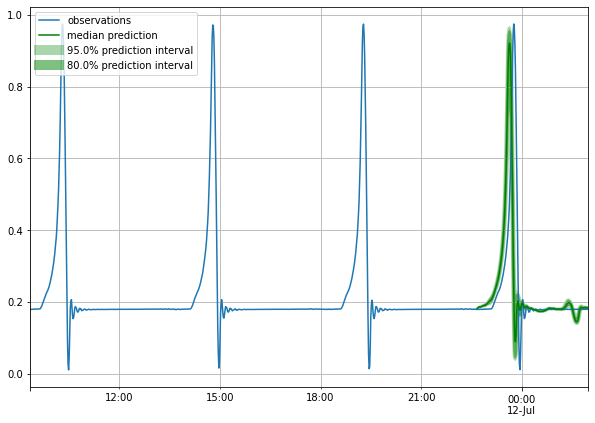

In [26]:
plot_prob_forecasts(tss[1], forecasts[1])
#peak time check - freq

In [ ]:
# the period for the spikes 
# x_0 = forecasts[0].start_date.to_pydatetime()
# base_date = datetime.datetime.combine(x_0.date(), datetime.datetime.min.time())
# print(x_0 + datetime.timedelta(minutes=900) - base_date)
# x_unit = 1  # 1 minute
# x_ticks = np.linspace(0, len(forecasts[0].samples)-1, 10, dtype=int)
# x_axis = [((datetime.datetime.min + (x_0 + datetime.timedelta(minutes=int(n) * x_unit) - base_date))).strftime('%H:%M:%S') for n in x_ticks]
# x_axis[-1]
# plt.plot(forecasts[1].samples)
# ax = plt.gca()
# ax.set_xticks(x_ticks)
# ax.set_xticklabels(x_axis)
# plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
# plt.show()

In [25]:
def toString(a):
  return str(a)

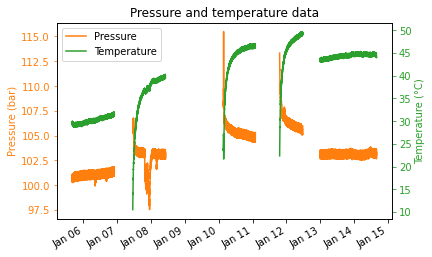

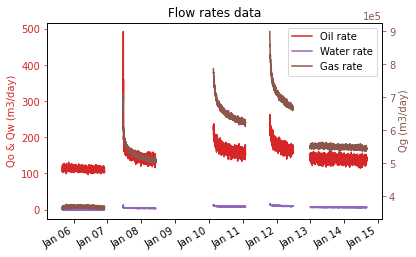

In [26]:
fp, headers, scaler = read_data_well('welltest.csv', plot_data=True)
df = pd.DataFrame.from_dict(dict(zip(['ds', 'pressure', 'temperature', 'oil', 'water', 'gas'], fp[0].T)))
for i in [1,2, 3, 4]:
    tmp = pd.DataFrame.from_dict(dict(zip(['ds', 'pressure', 'temperature', 'oil', 'water', 'gas'], fp[i].T)))
    df = pd.concat([df,tmp], axis=0)

In [27]:
df['date'] = df['ds'].apply(toString)
df = df.set_index('date')
df = df.drop(['ds'], axis=1)


In [28]:
prediction_length=300
training_data_uni_well = ListDataset(
    [{"start":df.index[0], "target":df.iloc[:5535, 3]}],
    freq = "1min"
)

In [29]:
model_1 = DeepAREstimator(freq='1min', context_length=600, \
                        prediction_length=prediction_length,num_layers=4, num_cells=256,\
                        cell_type='lstm', trainer=Trainer(epochs=10))

In [30]:
pred = model_1.train(training_data_uni_well)

100%|██████████| 50/50 [15:44<00:00, 18.88s/it, epoch=10/10, avg_epoch_loss=-2.34]


In [9]:
test_data = ListDataset(
    [{"start": df.index[0], "target": df.oil[:'2016-01-14 15:57:00']}],
    freq = "1min"
)

In [10]:
forecast_it, test_it = make_evaluation_predictions(
    dataset=test_data,
    predictor=pred, 
    num_samples=1000
)

In [11]:
forecasts = list(forecast_it)

In [13]:
tss = list(test_it)

In [14]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metric, item_metrics= evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


In [15]:
agg_metric

{'MSE': 0.0004458356648683548,
 'abs_error': 1.720740556716919,
 'abs_target_sum': 10.590263366699219,
 'abs_target_mean': 0.1059026336669922,
 'seasonal_error': 0.061168812071980584,
 'MASE': 0.2813101151436507,
 'MAPE': 0.16064849853515625,
 'sMAPE': 0.16612733840942384,
 'MSIS': 3.247163680811119,
 'QuantileLoss[0.1]': 0.7140866242349148,
 'Coverage[0.1]': 0.14,
 'QuantileLoss[0.5]': 1.7207407020032406,
 'Coverage[0.5]': 0.34,
 'QuantileLoss[0.9]': 1.302909120172262,
 'Coverage[0.9]': 0.57,
 'RMSE': 0.021114820976469464,
 'NRMSE': 0.19937956446734284,
 'ND': 0.16248326383720904,
 'wQuantileLoss[0.1]': 0.06742859922448574,
 'wQuantileLoss[0.5]': 0.16248327755606728,
 'wQuantileLoss[0.9]': 0.1230289630255299,
 'mean_absolute_QuantileLoss': 1.2459121488034726,
 'mean_wQuantileLoss': 0.11764694660202764,
 'MAE_Coverage': 0.17666666666666667,
 'OWA': nan}

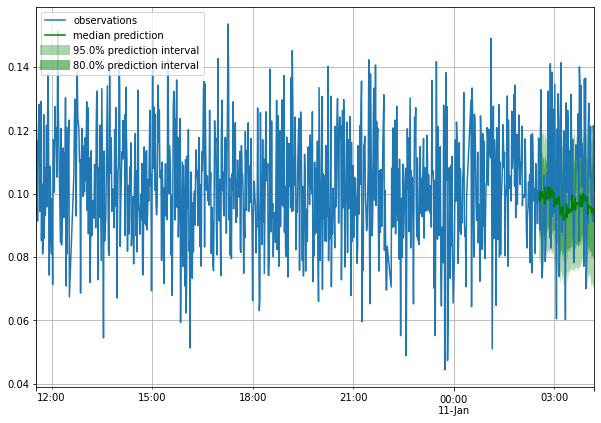

In [17]:
plot_prob_forecasts(tss[0], forecasts[0])

